In [2]:

import tensorflow as tf
#--------------------------------------
print(tf.__version__)
import random
random.seed(43)

print(tf.config.list_physical_devices('GPU'))
from tensorflow.compat.v1.keras import backend as K
config =  tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.
config.gpu_options.allow_growth = True
sess =  tf.compat.v1.Session(config=config)
K.set_session(sess)
tf.compat.v1.reset_default_graph()

from albumentations import OneOf, HorizontalFlip, VerticalFlip
from albumentations.augmentations.transforms import Rotate

from skimage.transform import resize

from tensorflow.keras import backend as k
from tensorflow.keras.layers import Dense, Conv2D, add, BatchNormalization, Dropout, Flatten, Reshape, LeakyReLU,UpSampling2D
from tensorflow.keras.models import Model 
import cv2
import numpy as np
import pandas as pd
import os
from PIL import Image
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from classification_models.tfkeras import Classifiers
import datetime
from livelossplot import PlotLossesKeras

import matplotlib.pyplot as plt
from focal_loss import SparseCategoricalFocalLoss
from focal_loss import BinaryFocalLoss
from sklearn.utils import class_weight


2.3.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
list_attr_celeba = pd.read_excel('../csv/list_attr_celeba.xlsx')
list_attr_celeba=list_attr_celeba[['file_name','Male']]

list_attr_celeba.rename(columns={'Male':'Gender'},inplace=True)

list_attr_celeba['Gender'] = list_attr_celeba['Gender'].replace([1],0)
list_attr_celeba['Gender'] = list_attr_celeba['Gender'].replace([-1],1)

list_attr_celeba.file_name = '../data/celeba_image/'+ list_attr_celeba.file_name

list_attr_celeba = list_attr_celeba[list_attr_celeba.file_name != '../data/celeba_image/093147.png']

msk = np.random.rand(len(list_attr_celeba)) < 0.80


list_attr_celeba_train = list_attr_celeba[msk]
list_attr_celeba_valid = list_attr_celeba[~msk]
     
    
list_attr_celeba_train = list_attr_celeba_train.reset_index(drop=True)
list_attr_celeba_valid = list_attr_celeba_valid.reset_index(drop=True)



print('train',len(list_attr_celeba_train))
print('valid',len(list_attr_celeba_valid))



train 162272
valid 40326


In [4]:
utk = pd.read_excel('../csv/utk.xlsx')
utk=utk[utk.Age >6]
utk=utk[['file_name','Gender']]
utk.file_name = '../data/utk/'+ utk.file_name

msk = np.random.rand(len(utk)) < 0.70


utk_train = utk[msk]
utk_valid = utk[~msk]
     
utk_train = utk_train.reset_index(drop=True)
utk_valid = utk_valid.reset_index(drop=True)


print('train',len(utk_train))
print('valid',len(utk_valid))


train 12754
valid 5475


In [5]:
all_race_and_mask_annotated = pd.read_excel('../csv/all_race_and_mask_annotated.xlsx')
all_race_and_mask_annotated=all_race_and_mask_annotated[all_race_and_mask_annotated.Age >6]
all_race_and_mask_annotated=all_race_and_mask_annotated[['file_name','Gender']]
all_race_and_mask_annotated.file_name = '../data/all_race_and_mask_annotated/'+ all_race_and_mask_annotated.file_name

msk = np.random.rand(len(all_race_and_mask_annotated)) < 0.70


all_race_and_mask_annotated_train = all_race_and_mask_annotated[msk]
all_race_and_mask_annotated_valid = all_race_and_mask_annotated[~msk]
     
all_race_and_mask_annotated_train = all_race_and_mask_annotated_train.reset_index(drop=True)
all_race_and_mask_annotated_valid = all_race_and_mask_annotated_valid.reset_index(drop=True)


print('train',len(all_race_and_mask_annotated_train))
print('valid',len(all_race_and_mask_annotated_valid))

train 8322
valid 3517


In [6]:
gender_data_test = pd.read_excel('../csv/gender_data_test.xlsx')
gender_data_test=gender_data_test[['file_name','Gender']]
gender_data_test.file_name = '../data/gender_data_test/'+ gender_data_test.file_name

msk = np.random.rand(len(gender_data_test)) < 0.70


gender_data_test_train = gender_data_test[msk]
gender_data_test_valid = gender_data_test[~msk]
     
gender_data_test_train = gender_data_test_train.reset_index(drop=True)
gender_data_test_valid = gender_data_test_valid.reset_index(drop=True)


print('train',len(gender_data_test_train))
print('valid',len(gender_data_test_valid))

train 1615
valid 692


In [7]:
train=pd.concat([list_attr_celeba_train,
                 utk_train,
                 all_race_and_mask_annotated_train,
                 gender_data_test_train])

valid=pd.concat([list_attr_celeba_valid,
                 utk_valid,
                 all_race_and_mask_annotated_valid,
                 gender_data_test_valid])
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

print('train',len(train))
print('valid',len(valid))



train 184963
valid 50010


In [8]:
def gen(df, batch_size = 100, w=178, h=218,istraing=False):
    df = df.reset_index(drop=True)
    augmenter = OneOf([HorizontalFlip(p = 0.4), VerticalFlip(p = 0.2),Rotate(p=0.4,limit=90)], p = 0.4)
    while True:
        samples_range = len(df)//batch_size
        for i in range(samples_range) :
            start = i * batch_size
            end = start + batch_size
            x =[];y=[];fname=[]
            for j in range (start, end):
                try :
                    y.append(df.loc[j]['Gender'])
                    img = cv2.imread(df.loc[j]['file_name'],cv2.IMREAD_COLOR)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img =cv2.resize(img, (w,h))
                    if istraing:
                        aug_dict = augmenter(image = img)
                        img = aug_dict['image']
                    x.append(img)
                    fname.append(j)
                except :
                    print(df.loc[j]['file_name'])
                    pass
            x = np.array(x)/255
            y = np.array(y)
            yield x, y

    


(20, 218, 178, 3)


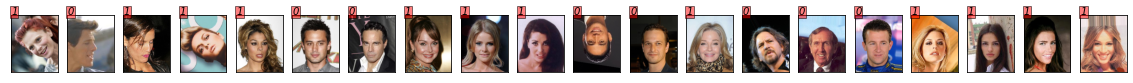

In [9]:

g_train = gen(train, batch_size = 20,istraing=True)
x, y = next(g_train) 

print(x.shape)

n = 20  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(0, n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x[i])
    ax.text(0.95, 0.01, '{}'.format(y[i]), style='italic',
    bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 1})

    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [10]:
def trainable_weights(model):
    print("weights:", len(model.weights))
    print("trainable_weights:", len(model.trainable_weights))
    print("non_trainable_weights:", len(model.non_trainable_weights))

In [11]:
def loss_apt_callbacks(lr,model,cost,metric, loss_weights, RUN_NAME,pa_estop=20,pa_Reduce=5):
    
    plotlosses = PlotLossesKeras()

    ReduceLROnPlateau =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=pa_Reduce, mode='min',min_delta=0.00001)  

    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('..','logs','models','{}.h5'.format(RUN_NAME)), save_best_only=True, verbose=1,mode='min') 

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.0001, patience=pa_estop, restore_best_weights=True)

    callbacks = [plotlosses, checkpoint,ReduceLROnPlateau]

#     opt = tf.keras.optimizers.Adam(learning_rate=lr)
#     opt= tf.keras.optimizers.SGD(lr=lr, momentum=0.9)
    init_lr = 1e-4
    epochs = 100
    opt = tf.keras.optimizers.Adam(lr=init_lr, decay=init_lr / epochs)

    model.compile(optimizer=opt, loss=cost, metrics=metric,loss_weights=loss_weights,)
    
    
    return model,callbacks

In [13]:
    
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

def recall_macro(y_true, y_pred):
    return recall_score(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1), average = 'macro', zero_division=0)
    
def tf_recall_macro(y_true, y_pred):
    return tf.py_function(recall_macro, inp=[y_true, y_pred], Tout=tf.float32)


def recall_micro(y_true, y_pred):
    return recall_score(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1), average = 'micro', zero_division=0)
    
def tf_recall_micro(y_true, y_pred):
    return tf.py_function(recall_micro, inp=[y_true, y_pred], Tout=tf.float32)



def precision_micro(y_true, y_pred):
    return precision_score(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1), average = 'micro', zero_division=0)
    
def tf_precision_micro(y_true, y_pred):
    return tf.py_function(precision_micro, inp=[y_true, y_pred], Tout=tf.float32)



def precision_macro(y_true, y_pred):
    return precision_score(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1), average = 'macro', zero_division=0)
    
def tf_precision_macro(y_true, y_pred):
    return tf.py_function(precision_macro, inp=[y_true, y_pred], Tout=tf.float32)



def f1_macro(y_true, y_pred):
    return f1_score(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1), average = 'macro', zero_division=0)
    
def tf_f1_macro(y_true, y_pred):
    return tf.py_function(f1_macro, inp=[y_true, y_pred], Tout=tf.float32)



def f1_micro(y_true, y_pred):
    return f1_score(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1), average = 'micro', zero_division=0)
    
def tf_f1_micro(y_true, y_pred):
    return tf.py_function(f1_micro, inp=[y_true, y_pred], Tout=tf.float32)


cost = {'gender_out':'sparse_categorical_crossentropy'}
      
# cost = {'gender_out': SparseCategoricalFocalLoss(gamma=2.)}

metric = {'gender_out':'accuracy'}


In [23]:
def train_model(model,callbacks,train,valid,epoches=500,batch_size=32,initial_epoch=0):
    
    steps_per_epoch = len(train)//batch_size
    validation_steps = len(valid)//batch_size
    
    train_set = gen(train, batch_size,198,198,True)
    valid_set = gen(valid, batch_size,198,198,False)
    hist = model.fit(train_set,steps_per_epoch=steps_per_epoch,
    validation_data = valid_set, validation_steps = validation_steps,
    initial_epoch =initial_epoch,epochs=epoches, shuffle=True, callbacks=callbacks, verbose=1)
    
    return hist

In [15]:
def create_model_mid_layer(input_layer,out_layer_Activation,out_layer_name,out_num_node,convf=[64],stop_gradient=False):
    
    layer = tf.keras.layers.Conv2D(128, 1)(input_layer)
    if  stop_gradient:
        layer=tf.stop_gradient(layer)

    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.Activation('relu')(layer)
    layer = tf.keras.layers.Dropout(.2)(layer)

    for f in convf:
        
        layer = tf.keras.layers.Conv2D(f, 3, padding='same')(layer)
        layer = tf.keras.layers.BatchNormalization()(layer)
        layer = tf.keras.layers.Activation('relu')(layer)
        layer = tf.keras.layers.Dropout(.2)(layer)

   
    layer = tf.keras.layers.GlobalAveragePooling2D()(layer)
    layer = tf.keras.layers.Dense(1024)(layer)
    layer = tf.keras.layers.Activation('relu')(layer)
    layer = tf.keras.layers.Dropout(.2)(layer)
    layer = tf.keras.layers.Dense(512)(layer)
    layer = tf.keras.layers.Activation('relu')(layer)
    layer = tf.keras.layers.Dropout(.2)(layer)
    layer = tf.keras.layers.Dense(128)(layer)
    layer = tf.keras.layers.Activation('relu')(layer)
    layer = tf.keras.layers.Dense(out_num_node)(layer)
    layer = tf.keras.layers.Activation(out_layer_Activation,name=out_layer_name)(layer)
    
    return layer
inputs = tf.keras.Input(shape=(218,178, 3))

InceptionV3=tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",input_shape=(218, 178, 3))

In [16]:

print("number of layers:", len(InceptionV3.layers))
x = InceptionV3.output
predictions=create_model_mid_layer(x,'softmax','gender_out',2,[32,64,128,256])    
gender_model = tf.keras.models.Model(InceptionV3.input, predictions)

trainable_weights(gender_model)

# tf.keras.utils.plot_model(gender_model,to_file="gender_model.png",
#     show_shapes=True,show_layer_names=True,rankdir="TB",expand_nested=False,dpi=96)

number of layers: 311
weights: 414
trainable_weights: 216
non_trainable_weights: 198


In [17]:
gender_model.trainable=True
for layer in gender_model.layers[:22]:
    layer.trainable = False
trainable_weights(gender_model)


weights: 414
trainable_weights: 203
non_trainable_weights: 211


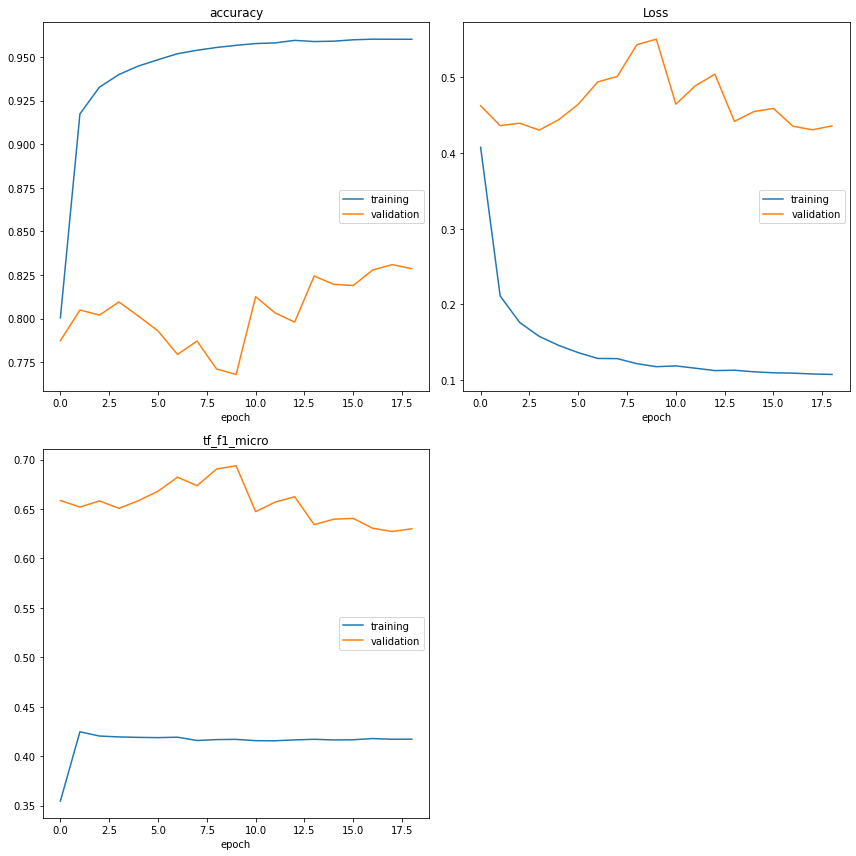

accuracy
	training         	 (min:    0.800, max:    0.960, cur:    0.960)
	validation       	 (min:    0.768, max:    0.831, cur:    0.829)
Loss
	training         	 (min:    0.108, max:    0.407, cur:    0.108)
	validation       	 (min:    0.430, max:    0.550, cur:    0.436)
tf_f1_micro
	training         	 (min:    0.355, max:    0.425, cur:    0.417)
	validation       	 (min:    0.627, max:    0.694, cur:    0.630)

Epoch 00019: val_loss did not improve from 0.43018
3359/3359 [==============================] - 763s 227ms/step - loss: 0.1077 - accuracy: 0.9602 - tf_f1_micro: 0.4172 - val_loss: 0.4357 - val_accuracy: 0.8287 - val_tf_f1_micro: 0.6300


In [18]:
RUN_NAME = 'InceptionV3_gender_model_v4'
gender_model,callbacks=loss_apt_callbacks(0.0001,gender_model,cost,metric,{},RUN_NAME,pa_estop=15,pa_Reduce=3)
hist=train_model(gender_model,callbacks,train,valid,300,64,initial_epoch=0)

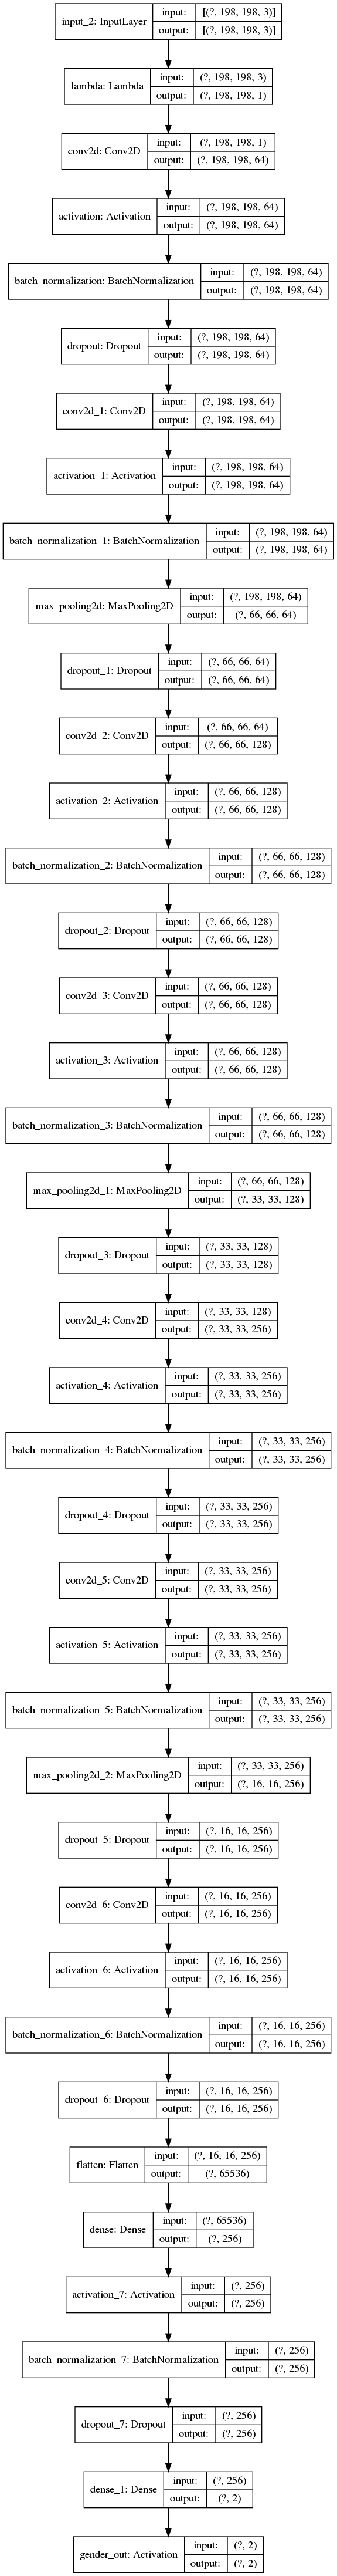

In [37]:
IM_WIDTH = IM_HEIGHT = 198
input_shape = (IM_HEIGHT, IM_WIDTH, 3)
inputs = tf.keras.layers.Input(shape=input_shape)

x = tf.keras.layers.Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

x = tf.keras.layers.Conv2D(64, (3, 3), padding="same")(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Conv2D(64, (3, 3), padding="same")(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3))(x)
x = tf.keras.layers.Dropout(0.25)(x)


x = tf.keras.layers.Conv2D(128, (3, 3), padding="same")(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), padding="same")(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Conv2D(256, (3, 3), padding="same")(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.Dropout(0.25)(x)


x = tf.keras.layers.Conv2D(256, (3, 3), padding="same")(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Conv2D(256, (3, 3), padding="same")(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2)(x)
gender_branch = tf.keras.layers.Activation("sigmoid", name="gender_out")(x)
gender_model = Model(inputs=inputs,outputs =  gender_branch)
tf.keras.utils.plot_model(gender_model,to_file="gender_model.png",
    show_shapes=True,show_layer_names=True,rankdir="TB",expand_nested=False,dpi=96)

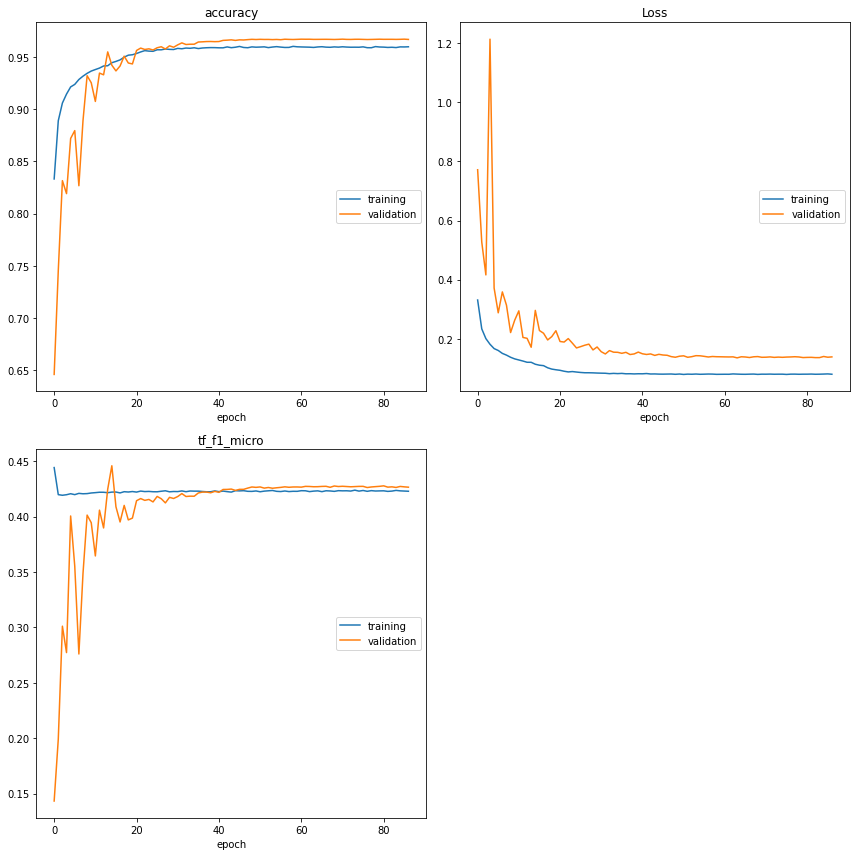

accuracy
	training         	 (min:    0.833, max:    0.960, cur:    0.960)
	validation       	 (min:    0.646, max:    0.967, cur:    0.967)
Loss
	training         	 (min:    0.080, max:    0.331, cur:    0.080)
	validation       	 (min:    0.136, max:    1.213, cur:    0.139)
tf_f1_micro
	training         	 (min:    0.419, max:    0.444, cur:    0.423)
	validation       	 (min:    0.143, max:    0.446, cur:    0.427)

Epoch 00087: val_loss did not improve from 0.13569
2886/2886 [==============================] - 839s 291ms/step - loss: 0.0803 - accuracy: 0.9598 - tf_f1_micro: 0.4228 - val_loss: 0.1390 - val_accuracy: 0.9668 - val_tf_f1_micro: 0.4265
Epoch 88/100
2271/2886 [======================>.......] - ETA: 2:22 - loss: 0.0420 - accuracy: 0.9846 - tf_f1_micro: 0.4193

KeyboardInterrupt: 

In [15]:
RUN_NAME = 'gender_model_v2'
gender_model,callbacks=loss_apt_callbacks(0.0001,gender_model,cost,metric,{},RUN_NAME,pa_estop=15,pa_Reduce=3)
hist=train_model(gender_model,callbacks,train,valid,100,64,initial_epoch=0)

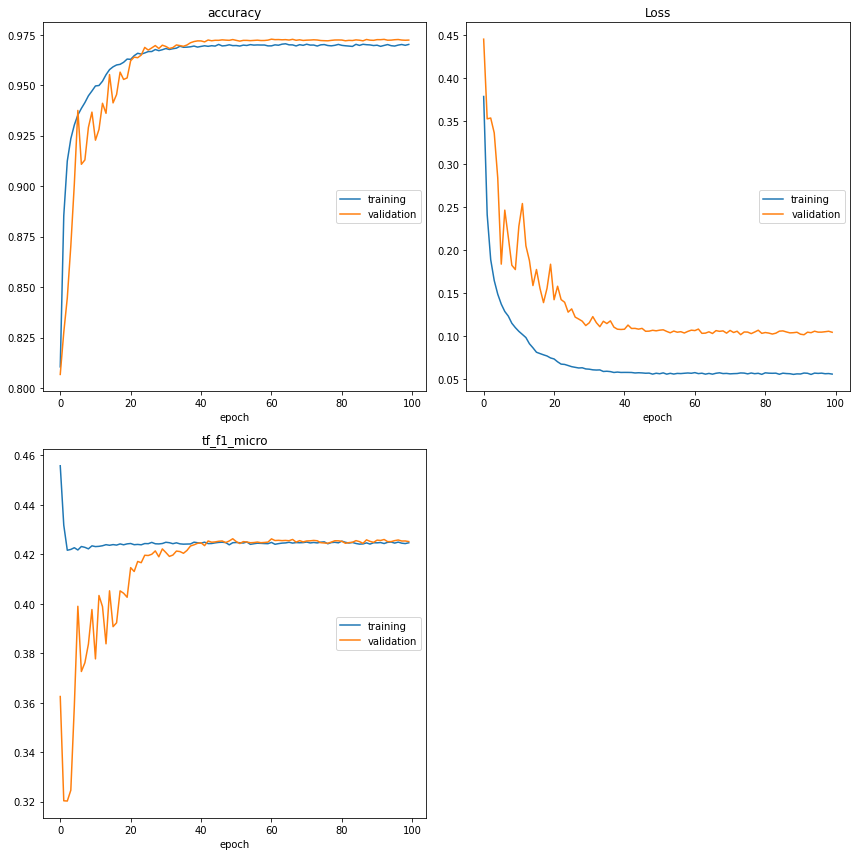

accuracy
	training         	 (min:    0.811, max:    0.971, cur:    0.970)
	validation       	 (min:    0.807, max:    0.973, cur:    0.972)
Loss
	training         	 (min:    0.056, max:    0.379, cur:    0.056)
	validation       	 (min:    0.102, max:    0.446, cur:    0.105)
tf_f1_micro
	training         	 (min:    0.422, max:    0.456, cur:    0.425)
	validation       	 (min:    0.320, max:    0.426, cur:    0.425)

Epoch 00100: val_loss did not improve from 0.10173
2886/2886 [==============================] - 833s 288ms/step - loss: 0.0559 - accuracy: 0.9702 - tf_f1_micro: 0.4246 - val_loss: 0.1046 - val_accuracy: 0.9723 - val_tf_f1_micro: 0.4251


In [38]:
RUN_NAME = 'gender_model_v3'
gender_model,callbacks=loss_apt_callbacks(0.0001,gender_model,cost,metric,{},RUN_NAME,pa_estop=15,pa_Reduce=3)
hist=train_model(gender_model,callbacks,train,valid,100,64,initial_epoch=0)

In [90]:
model=tf.keras.models.load_model('../logs/models/gender_model_v3.h5',custom_objects={'tf_f1_micro':tf_f1_micro})

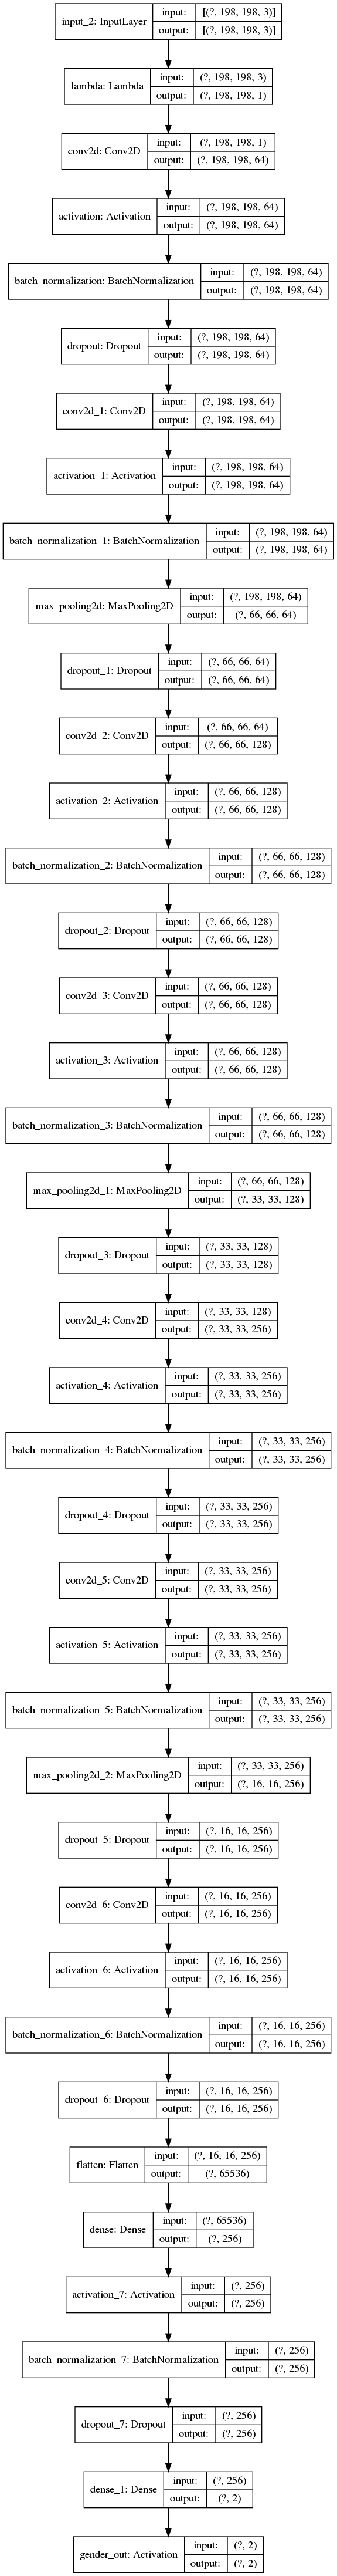

In [14]:
model=tf.keras.models.load_model('../logs/models/gender_model_v3.h5',custom_objects={'tf_f1_micro':tf_f1_micro})
x = tf.keras.layers.Activation('softmax',name='gender_out')(model.layers[-2].output)
gender_model = tf.keras.models.Model(inputs=model.input,outputs =x)

tf.keras.utils.plot_model(gender_model,to_file="gender_model.png",
    show_shapes=True,show_layer_names=True,rankdir="TB",expand_nested=False,dpi=96)





In [24]:
from tqdm.notebook import tqdm
# train=pd.concat([list_attr_celeba_train,
#                  utk_train,
#                  all_race_and_mask_annotated_train,
#                  gender_data_test_train])

# valid=pd.concat([list_attr_celeba_valid,
#                  utk_valid,
#                  all_race_and_mask_annotated_valid,
#                  gender_data_test_valid])
v=list_attr_celeba_valid
batch_size=100
g_train = gen(v,w=198, h=198, batch_size = batch_size,istraing=False)
y_p=[]
y_t=[]
for _ in tqdm(range(len(v)//30)):
    x, y = next(g_train) 
    y_p.extend(np.argmax(gender_model.predict(x), axis=1))
    y_t.extend(y)


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_t, y_p))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     55747
           1       0.99      1.00      1.00     78653

    accuracy                           0.99    134400
   macro avg       0.99      0.99      0.99    134400
weighted avg       0.99      0.99      0.99    134400



In [22]:
gender_model.layers[-1].output

<tf.Tensor 'gender_out/Softmax:0' shape=(None, 2) dtype=float32>

0 [9.403320e-03 9.999059e+01]
0 [3.5776797e-04 9.9999641e+01]


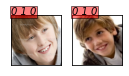

0 [26.125723 73.87428 ]
0 [34.340923 65.65907 ]


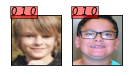

0 [28.538631 71.461365]
0 [ 0.13288237 99.86712   ]
0 [32.931778 67.06822 ]


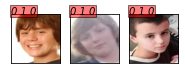

0 [ 5.575327 94.424675]


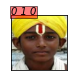

0 [ 1.3188186 98.68118  ]


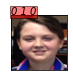

0 [17.305283 82.69472 ]
0 [ 0.24909133 99.750916  ]


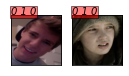

0 [1.18653494e-04 9.99998779e+01]
0 [32.81079 67.18921]


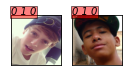

1 [50.017548 49.982452]


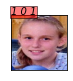

0 [ 3.9154139 96.08458  ]


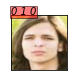

0 [ 3.534972 96.465034]


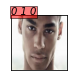

0 [23.743967 76.256035]


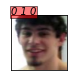

0 [39.076344 60.923653]


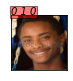

0 [44.320194 55.679806]


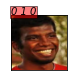

0 [ 0.5245011 99.4755   ]
0 [15.430911 84.569084]
0 [ 7.9357357 92.06427  ]


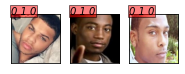

0 [11.284408 88.71559 ]
0 [4.6133282e-05 9.9999954e+01]


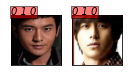

0 [ 1.5241793 98.47582  ]


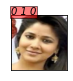

0 [13.534449 86.46555 ]
0 [ 9.678013 90.32199 ]


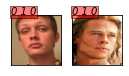

0 [ 3.1937792 96.80623  ]


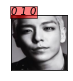

1 [65.15924  34.840755]
1 [92.152084   7.8479147]


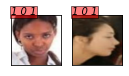

0 [12.916179 87.08382 ]


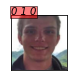

0 [ 0.34508675 99.654915  ]


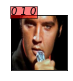

0 [ 6.543754 93.456245]
0 [42.07571 57.92429]
0 [ 1.2595334 98.74047  ]
0 [ 0.67954105 99.32046   ]
0 [ 4.544845 95.455154]
0 [9.6749345e-06 9.9999985e+01]


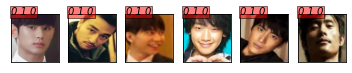

0 [ 1.9455162 98.05448  ]


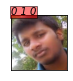

1 [90.82796   9.172035]


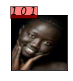

1 [75.2756   24.724405]
1 [51.850403 48.149593]


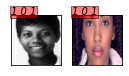

0 [36.729378 63.270622]
0 [ 0.86882484 99.13118   ]


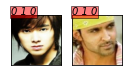

1 [67.29638 32.70362]


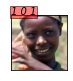

0 [22.886028 77.113976]
0 [ 0.24495576 99.75504   ]
0 [ 5.6037154 94.396286 ]


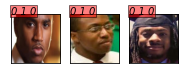

0 [ 4.3303866 95.66961  ]
0 [1.7590718e-02 9.9982414e+01]


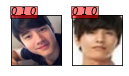

1 [68.0888   31.911205]


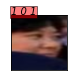

1 [66.763245 33.23675 ]


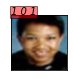

0 [40.95252  59.047478]


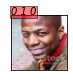

0 [ 0.7685779 99.23143  ]
0 [5.1834725e-02 9.9948174e+01]


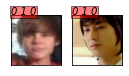

1 [70.325615 29.674383]


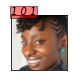

1 [67.26588  32.734127]


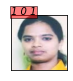

0 [47.698116 52.301884]


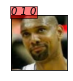

0 [ 2.9782243 97.02178  ]
0 [41.30571 58.69429]


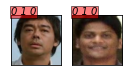

1 [77.2633   22.736702]


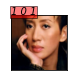

0 [41.679337 58.32066 ]


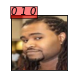

0 [30.229347 69.77065 ]


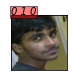

1 [55.89459 44.10541]


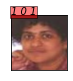

0 [31.305473 68.69453 ]


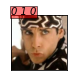

0 [3.4897195e-03 9.9996506e+01]
0 [10.255512 89.74449 ]


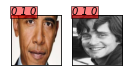

0 [17.2612 82.7388]
0 [ 0.26767978 99.73232   ]


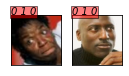

1 [9.9999870e+01 1.2645421e-04]


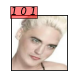

0 [27.110678 72.88932 ]


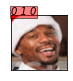

0 [47.012867 52.98714 ]


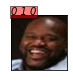

1 [60.76154  39.238457]


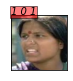

0 [1.8241374e-02 9.9981766e+01]


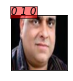

1 [9.9995125e+01 4.8739067e-03]


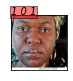

0 [14.288428 85.71158 ]


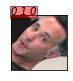

1 [87.99827  12.001731]


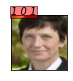

1 [78.811905 21.188099]
0 [14.225298 85.774704]


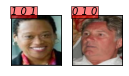

0 [7.477843e-05 9.999993e+01]
1 [76.684975 23.315018]


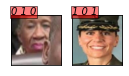

1 [87.50684  12.493155]


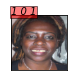

0 [6.8036127e-03 9.9993195e+01]
0 [7.007819e-02 9.992992e+01]
0 [10.821351 89.17864 ]


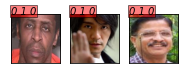

0 [32.1543 67.8457]


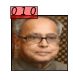

1 [90.66275   9.337255]


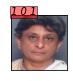

0 [2.2475098e-03 9.9997749e+01]
1 [98.43315    1.5668488]


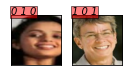

0 [4.0498964e-02 9.9959496e+01]


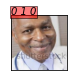

0 [40.848675 59.15133 ]


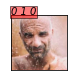

1 [89.37851  10.621489]
0 [ 0.12562732 99.874374  ]


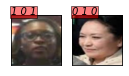

0 [ 7.5745173 92.42548  ]


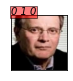

1 [95.400696   4.5992994]


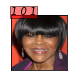

0 [35.725063 64.27494 ]


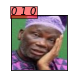

1 [65.28184  34.718166]


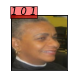

1 [86.95424  13.045766]


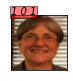

0 [17.731308 82.26869 ]


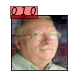

0 [45.943443 54.05655 ]


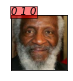

1 [93.35328   6.646722]


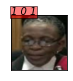

1 [77.65752  22.342487]


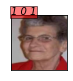

1 [67.35175  32.648243]


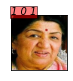

0 [14.946574 85.05342 ]
0 [7.7152145e-03 9.9992287e+01]
0 [2.2333122e-03 9.9997772e+01]


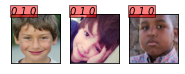

0 [ 5.494764 94.50524 ]
0 [2.8927568e-03 9.9997101e+01]
0 [34.56443 65.43556]
0 [24.758793 75.24121 ]


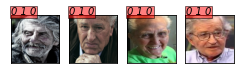

1 [53.665638 46.334362]
1 [9.9970428e+01 2.9570807e-02]


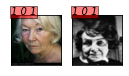

1 [98.6552    1.344808]


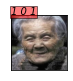

1 [62.003304 37.9967  ]
1 [50.528175 49.471825]
1 [91.024994  8.974999]
1 [63.947075 36.05293 ]
1 [92.92843  7.07158]


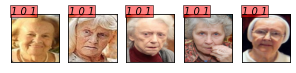

1 [81.37813  18.621874]
1 [63.56128  36.438725]
1 [99.626854   0.3731497]
1 [85.29167 14.70833]


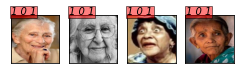

0 [5.1141683e-02 9.9948860e+01]
0 [ 5.786667 94.21333 ]
0 [24.434753 75.56525 ]


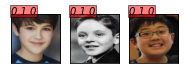

1 [87.834816 12.165181]


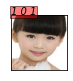

0 [22.987312 77.01269 ]


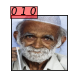

1 [98.73095   1.269046]
1 [64.481    35.518993]
1 [77.73067  22.269339]
1 [9.9999657e+01 3.4998966e-04]
1 [99.183136   0.8168691]
1 [79.08464  20.915361]


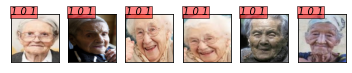

0 [ 7.01423 92.98576]
0 [40.854588 59.145416]
0 [12.35429 87.64571]
0 [19.123266 80.87674 ]
0 [ 5.887286 94.11272 ]
0 [38.74563  61.254375]


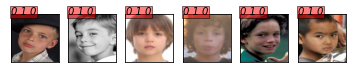

In [23]:
## g_train = gen(train,w=198, h=198, batch_size = 30,istraing=False)
g_train = gen(utk_valid,w=198, h=198, batch_size = 30,istraing=False)
from tqdm.notebook import tqdm

for _ in tqdm(range(len(utk_valid)//30)):
    x, y = next(g_train) 
    f=y
    CON=gender_model.predict(x)
    y_p = np.argmax(CON, axis=1)
    CON=CON*100
    incorrects = np.nonzero(y_p != y)
    
    n = len(incorrects[0])  # how many digits we will display
    if not n == 0:
        plt.figure(figsize=(n, 4))
        j=0
        for i in incorrects[0]:
            # display original
            ax = plt.subplot(2, n, j + 1)
            plt.imshow(x[i])
            print(f[i],CON[i])
            ax.text(0.2, 0.08, '{} {} {}'.format(y[i],y_p[i],f[i]), style='italic',
            bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 1})

            # plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            j+=1

        plt.show()

In [55]:
model=tf.keras.models.load_model('../logs/models/gender_model_v3.h5',custom_objects={'tf_f1_micro':tf_f1_micro})
model.trainable = False
model.layers[-2].trainable=True


x = tf.keras.layers.Activation('softmax',name='gender_out')(model.layers[-2].output)
gender_model = tf.keras.models.Model(inputs=model.input,outputs =x)

# tf.keras.utils.plot_model(gender_model,to_file="gender_model.png",
#     show_shapes=True,show_layer_names=True,rankdir="TB",expand_nested=False,dpi=96)



In [19]:
print('data = ' ,len(valid))
batch_size=100
evl_steps = len(valid)//batch_size
evl_set = gen(valid,w=198, h=198, batch_size = batch_size,istraing=False)
gender_model.compile(loss=cost, metrics=metric)

t=gender_model.evaluate(evl_set, batch_size=batch_size,steps=evl_steps)

data =  50010
500/500 [==============================] - 165s 329ms/step - loss: 0.0735 - accuracy: 0.9863
